In [ ]:
import torch
obj = torch.load('../pretrained_model/Model_50_gen.pth', map_location='cpu')
print(type(obj))
# 若打印 <class 'collections.OrderedDict'> 说明是 state_dict
# 若打印 <class 'torch.nn.modules...'> 或自定义类，则是整个模型


In [ ]:
import pandas as pd

# 1. 载入 state_dict
pth_path = '../pretrained_model/Model_50_gen.pth'   # 用户上传的文件路径
state_dict = torch.load(pth_path, map_location='cpu')  # 只查看即可，用 CPU 即可

# 2. 整理为 DataFrame：参数名、形状、参数数量
rows = []
for name, tensor in state_dict.items():
    # 忽略非 Tensor（极少见），仅记录 Tensor 权重/缓冲区
    if isinstance(tensor, torch.Tensor):
        rows.append({
            "Parameter": name,
            "Shape": tuple(tensor.shape),
            "Num Params": tensor.numel(),
        })

df = pd.DataFrame(rows)
print(df)

/scratch-local/72814/ipykernel_633568/2990444627.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pth_path, map_location='cpu')  # 只查看即可，用 CPU 即可


                               Parameter          Shape  Num Params
0        sal_encoder.resnet.conv1.weight  (64, 3, 7, 7)        9408
1          sal_encoder.resnet.bn1.weight          (64,)          64
2            sal_encoder.resnet.bn1.bias          (64,)          64
3    sal_encoder.resnet.bn1.running_mean          (64,)          64
4     sal_encoder.resnet.bn1.running_var          (64,)          64
..                                   ...            ...         ...
900                 x_encoder.fc2_2.bias           (3,)           3
901               x_encoder.fc1_3.weight     (3, 50176)      150528
902                 x_encoder.fc1_3.bias           (3,)           3
903               x_encoder.fc2_3.weight     (3, 50176)      150528
904                 x_encoder.fc2_3.bias           (3,)           3

[905 rows x 3 columns]


In [ ]:
import torch
import re
from collections import defaultdict

state_dict = torch.load("../pretrained_model/Model_50_gen.pth", map_location="cpu")

layer_block_counts = defaultdict(set)

# 正则匹配所有 layerX_Y.Z 结构
pat = re.compile(r"resnet\.layer([1-4])_([12])\.([0-9]+)\.conv1\.weight")

for name in state_dict:
    match = pat.search(name)
    if match:
        layer = int(match.group(1))  # 层号
        group = int(match.group(2))  # _1, _2 是分支组？
        block = int(match.group(3))  # block 索引
        key = f"layer{layer}_{group}"
        layer_block_counts[key].add(block)

# 展示统计结果
for k, v in layer_block_counts.items():
    print(f"{k}: {len(v)} blocks")

/scratch-local/72814/ipykernel_633568/1225608410.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("../pretrained_model/Model_50_gen.pth", map_loca

layer3_1: 6 blocks
layer4_1: 3 blocks
layer3_2: 6 blocks
layer4_2: 3 blocks


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from torchmetrics import JaccardIndex
import math


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class B2_ResNet(nn.Module):
    # ResNet50 with two branches
    def __init__(self):
        # self.inplanes = 128
        self.inplanes = 64
        super(B2_ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3_1 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4_1 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.inplanes = 512
        self.layer3_2 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4_2 = self._make_layer(Bottleneck, 512, 3, stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x1 = self.layer3_1(x)
        x1 = self.layer4_1(x1)

        x2 = self.layer3_2(x)
        x2 = self.layer4_2(x2)

        return x1, x2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = B2_ResNet().to(device)
state_dict = torch.load('../pretrained_model/Model_50_gen.pth', map_location='cpu')
model.load_state_dict(state_dict, strict=False)
model.eval()


/scratch-local/72814/ipykernel_633568/3719410558.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('../pretrained_model/Model_50_gen.pth', map_loca

B2_ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms

class SegmentationDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        mask = np.load(self.mask_paths[idx])  # 使用 numpy 加载 .npy 文件
        if self.transform:
            img, mask = self.transform(img, mask)
        return img, mask

# Example transforms：resize + to_tensor + normalize
def seg_transform(img, mask):
    t_img = transforms.Compose(
        [
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    # 对于 mask，直接使用 PyTorch 的操作
    mask = torch.from_numpy(mask).long()  # 转换为 LongTensor
    mask = torch.nn.functional.interpolate(
        mask.unsqueeze(0).unsqueeze(0).float(),  # 添加 batch 和 channel 维度
        size=(512, 512),
        mode="nearest",
    ).squeeze(0).squeeze(0).long()  # 恢复原始形状并转换回 LongTensor
    return t_img(img), mask

# 构建 DataLoader
val_imgs = ["/home/ytao/Thesis/smoke-segmentation.v5i.coco-segmentation/test/hoogovens_6_7__2024-11-03T07-38-21Z_frame_927_jpg.rf.b585fee20b605ecd1bdeb0553a2f4040.jpg"]
val_masks = ["/home/ytao/Thesis/smoke-segmentation.v5i.coco-segmentation/masks/hoogovens_6_7__2024-11-03T07-38-21Z_frame_927_jpg.rf.b585fee20b605ecd1bdeb0553a2f4040.npy"]

val_dataset = SegmentationDataset(val_imgs, val_masks, transform=seg_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
/home/ytao/anaconda3/envs/dl2024/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ytao/anaconda3/envs/dl2024/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ytao/anaconda3/envs/dl2024/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ytao/anaconda3/envs/dl2024/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu S

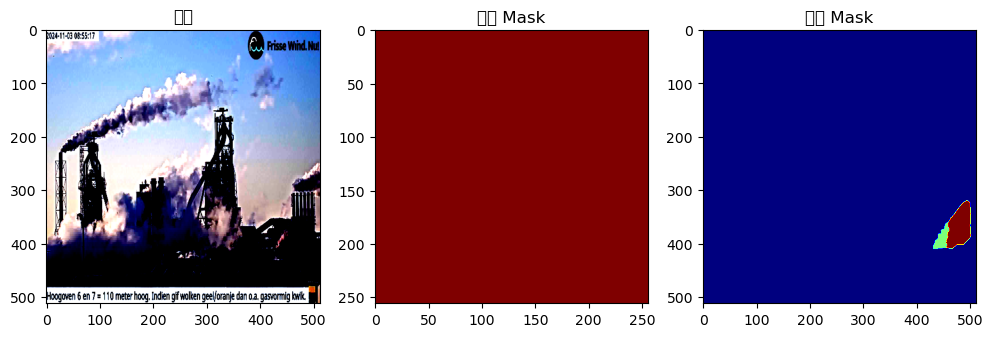

In [ ]:
def visualize_segmentation(image, mask_pred, mask_gt=None):
    fig, axes = plt.subplots(1, 2 if mask_gt is None else 3, figsize=(12,4))
    axes[0].imshow(image.permute(1,2,0).cpu().numpy())
    axes[0].set_title('Orignal')
    
    # 添加透明度和颜色一致的图例
    cmap = plt.cm.get_cmap('jet', 3)  # 假设有3个类别
    im = axes[1].imshow(mask_pred.cpu(), cmap=cmap, vmin=0, vmax=3-1, alpha=0.7)
    axes[1].set_title('Predicted Mask')
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label='Classes')
    
    if mask_gt is not None:
        im_gt = axes[2].imshow(mask_gt.cpu(), cmap=cmap, vmin=0, vmax=3-1, alpha=0.7)
        axes[2].set_title('True Mask')
        fig.colorbar(im_gt, ax=axes[2], fraction=0.046, pad=0.04, label='Classes')
    
    plt.show()

# 单张样本推理
model.eval()
with torch.inference_mode():
    img, gt = next(iter(val_loader))
    img = img.to(device)
    out1, out2 = model(img)    # 返回两条分支 x1,x2
    # 假设我们用 x2 作为分割输出，先上采样到原图大小，再取 argmax
    logits = nn.functional.interpolate(out2, size=(256,256), mode='bilinear', align_corners=False)
    pred = logits.argmax(dim=1)
visualize_segmentation(img[0].cpu(), pred[0], gt[0])
